# Refined Modeling Using 12 Order Classifications

In [1]:
# Imports & Setup:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

### Read in Data

In [2]:
# function to load in and process images
def load_image(path):
    images = Image.open(f'./../CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

In [3]:
class_map_dir= pd.read_csv('Tables/class_map_dir_output_new_classes_f.csv')
class_map_dir.head(5)

,F1,Image Id,Image Name,Is Training Image,Class Id,Class Name,Species Gen,Order,Order_Num_Seq,Species,Species_Num_Seq,Family,Family_Num_Seq
0,0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
1,1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
2,2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
3,3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
4,4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11


In [103]:
class_names=[
"ANSERIFORMES",
"CAPRIMULGIFORMES",
"CHARADRIIFORMES",
"CORACIIFORMES",
"CUCULIFORMES",
"GAVIIFORMES",
"PASSERIFORMES",
"PELECANIFORMES",
"PICIFORMES",
"PODICIPEDIFORMES",
"PROCELLARIIFORMES",
"SULIFORMES"
]

In [104]:
proper_class_names=[i.title() for i in class_names]

In [130]:
order_names_sorted=list(enumerate(proper_class_names, start=1))
order_names_sorted

[(1, 'Anseriformes'),
 (2, 'Caprimulgiformes'),
 (3, 'Charadriiformes'),
 (4, 'Coraciiformes'),
 (5, 'Cuculiformes'),
 (6, 'Gaviiformes'),
 (7, 'Passeriformes'),
 (8, 'Pelecaniformes'),
 (9, 'Piciformes'),
 (10, 'Podicipediformes'),
 (11, 'Procellariiformes'),
 (12, 'Suliformes')]

In [140]:
class_names_dict={
0:"ANSERIFORMES",
1:"CAPRIMULGIFORMES",
2:"CHARADRIIFORMES",
3:"CORACIIFORMES",
4:"CUCULIFORMES",
5:"GAVIIFORMES",
6:"PASSERIFORMES",
7:"PELECANIFORMES",
8:"PICIFORMES",
9:"PODICIPEDIFORMES",
10:"PROCELLARIIFORMES",
11:"SULIFORMES"
}

In [144]:
class_names_dict.get(7).title()

'Pelecaniformes'

## Build Neural Networks


#### Prep Train/Test Split & Labels

In [6]:
class_map_dir_train=class_map_dir.loc[class_map_dir['Is Training Image']==1]
list_of_images_train=[load_image(i) for i in class_map_dir_train['Image Name']]
array_of_img_train=np.asarray(list_of_images_train)
list_of_labels_train=class_map_dir_train['Order_Num_Seq']

In [7]:
class_map_dir_test=class_map_dir.loc[class_map_dir['Is Training Image']==0]
list_of_images_test=[load_image(i) for i in class_map_dir_test['Image Name']]
array_of_img_test=np.asarray(list_of_images_test)
list_of_labels_test=class_map_dir_test['Order_Num_Seq']

In [9]:
# sanity check length of train datasets
print(len(list_of_images_train))
print(len(list_of_labels_train))

# sanity check length of test datasets
print(len(list_of_images_test))
print(len(list_of_labels_test))

5994
5994
5794
5794


In [8]:
X_train_alt=array_of_img_train
y_train_alt=list_of_labels_train

X_test_alt=array_of_img_test
y_test_alt=list_of_labels_test

X_train_alt = X_train_alt.reshape(X_train_alt.shape[0], 128, 128, 3)
X_test_alt = X_test_alt.reshape(X_test_alt.shape[0], 128, 128, 3)
y_train_alt = utils.to_categorical(y_train_alt,13)
y_test_alt = utils.to_categorical(y_test_alt,13)


### Run Preliminary Models 

In [8]:
model_alt = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
model_alt.add(Flatten(input_shape = (128, 128, 3)))
model_alt.add(Dense(512, activation = 'relu'))
model_alt.add(Dense(512, activation = 'relu'))
model_alt.add(Dense(256, activation = 'relu'))

model_alt.add(Dense(13, activation = 'softmax'))
# Compile model.
model_alt.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_alt  = model_alt.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=50,
                    verbose=1)

Epoch 1/50
24/24 [==============================] - 26s 898ms/step - loss: 14.5868 - accuracy: 0.4840 - val_loss: 9.6084 - val_accuracy: 0.0369
Epoch 2/50
24/24 [==============================] - 20s 853ms/step - loss: 5.2509 - accuracy: 0.4975 - val_loss: 1.8714 - val_accuracy: 0.6707
Epoch 3/50
24/24 [==============================] - 18s 775ms/step - loss: 1.5099 - accuracy: 0.6456 - val_loss: 1.2998 - val_accuracy: 0.6605
Epoch 4/50
24/24 [==============================] - 21s 872ms/step - loss: 1.2976 - accuracy: 0.6562 - val_loss: 1.3007 - val_accuracy: 0.6745
Epoch 5/50
24/24 [==============================] - 19s 798ms/step - loss: 1.3044 - accuracy: 0.6627 - val_loss: 1.2355 - val_accuracy: 0.6752
Epoch 6/50
24/24 [==============================] - 18s 750ms/step - loss: 1.2533 - accuracy: 0.6660 - val_loss: 1.2444 - val_accuracy: 0.6766
Epoch 7/50
24/24 [==============================] - 18s 754ms/step - loss: 1.2606 - accuracy: 0.6605 - val_loss: 1.2221 - val_accuracy: 0.680

In [41]:
model_alt.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               25166336  
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                      

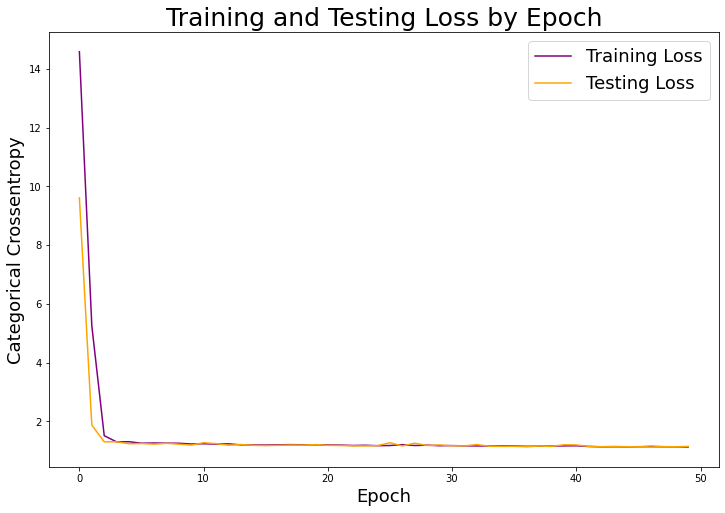

In [13]:
# Check out our train loss and test loss over epochs.
train_loss = history_alt.history['loss']
test_loss = history_alt.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='purple')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

In [9]:
model_alt2 = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
model_alt2.add(Conv2D(filters = 6, # number of filters
                     kernel_size = (3, 3), # height/width of filter
                     activation = 'relu', # activation function
                     input_shape = (128, 128, 3)# shape of input (image)
                     ))  
model_alt2.add(Flatten(input_shape = (128, 128, 3)))
model_alt2.add(Dense(512, activation = 'relu'))
model_alt2.add(Dense(512, activation = 'relu'))
model_alt2.add(Dense(256, activation = 'relu'))

model_alt2.add(Dense(13, activation = 'softmax'))
# Compile model.
model_alt2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_alt2  = model_alt2.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=50,
                    verbose=1)

Epoch 1/50
24/24 [==============================] - 57s 2s/step - loss: 7.0618 - accuracy: 0.4658 - val_loss: 2.5195 - val_accuracy: 0.6755
Epoch 2/50
24/24 [==============================] - 54s 2s/step - loss: 1.7030 - accuracy: 0.6650 - val_loss: 1.4561 - val_accuracy: 0.6755
Epoch 3/50
24/24 [==============================] - 55s 2s/step - loss: 1.4437 - accuracy: 0.6650 - val_loss: 1.3825 - val_accuracy: 0.6755
Epoch 4/50
24/24 [==============================] - 50s 2s/step - loss: 1.3733 - accuracy: 0.6650 - val_loss: 1.3374 - val_accuracy: 0.6755
Epoch 5/50
24/24 [==============================] - 52s 2s/step - loss: 1.3326 - accuracy: 0.6650 - val_loss: 1.2901 - val_accuracy: 0.6755
Epoch 6/50
24/24 [==============================] - 49s 2s/step - loss: 1.3079 - accuracy: 0.6650 - val_loss: 1.2688 - val_accuracy: 0.6752
Epoch 7/50
24/24 [==============================] - 48s 2s/step - loss: 1.2908 - accuracy: 0.6652 - val_loss: 1.2484 - val_accuracy: 0.6752
Epoch 8/50
24/24 [==

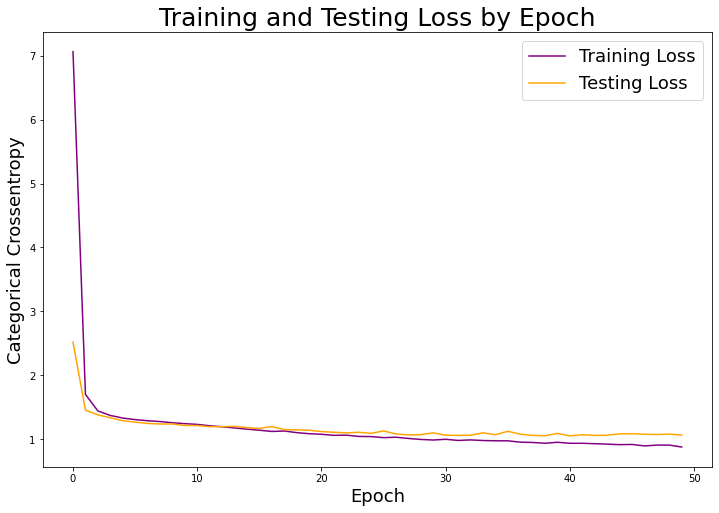

In [15]:
# Check out our train loss and test loss over epochs.
train_loss = history_alt2.history['loss']
test_loss = history_alt2.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='purple')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

In [16]:
model_alt5 = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
model_alt5.add(Conv2D(filters = 6, # number of filters
                     kernel_size = (3, 3), # height/width of filter
                     activation = 'relu', # activation function
                     input_shape = (128, 128, 3)# shape of input (image)
                     ))  
model_alt5.add(MaxPooling2D(pool_size = (2, 2))) # dimensions of region of pooling
model_alt5.add(Conv2D(16,
                     kernel_size = (3, 3),
                     activation = 'relu'))
model_alt5.add(MaxPooling2D(pool_size=(2, 2)))
model_alt5.add(Flatten(input_shape = (128, 128, 3)))
model_alt5.add(Dense(200, activation = 'relu'))
model_alt5.add(Dense(128, activation = 'relu'))
model_alt5.add(Dense(128, activation = 'relu'))
model_alt5.add(Dense(64, activation = 'relu'))
model_alt5.add(Dense(48, activation = 'relu'))

model_alt5.add(Dense(13, activation = 'softmax'))
# Compile model.
model_alt5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_alt5  = model_alt5.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=30,
                    verbose=1)

Epoch 1/30
24/24 [==============================] - 41s 2s/step - loss: 1.4555 - accuracy: 0.6400 - val_loss: 1.3088 - val_accuracy: 0.6755
Epoch 2/30
24/24 [==============================] - 45s 2s/step - loss: 1.3033 - accuracy: 0.6650 - val_loss: 1.2555 - val_accuracy: 0.6755
Epoch 3/30
24/24 [==============================] - 44s 2s/step - loss: 1.2507 - accuracy: 0.6650 - val_loss: 1.2215 - val_accuracy: 0.6755
Epoch 4/30
24/24 [==============================] - 43s 2s/step - loss: 1.2080 - accuracy: 0.6745 - val_loss: 1.1744 - val_accuracy: 0.6899
Epoch 5/30
24/24 [==============================] - 43s 2s/step - loss: 1.1766 - accuracy: 0.6849 - val_loss: 1.1514 - val_accuracy: 0.6880
Epoch 6/30
24/24 [==============================] - 38s 2s/step - loss: 1.1619 - accuracy: 0.6818 - val_loss: 1.1180 - val_accuracy: 0.6978
Epoch 7/30
24/24 [==============================] - 38s 2s/step - loss: 1.1320 - accuracy: 0.6915 - val_loss: 1.1221 - val_accuracy: 0.6888
Epoch 8/30
24/24 [==

## Transfer Learning

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#base_model.summary()

In [13]:
model2 = Sequential([ base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model2.add(Flatten(input_shape = (128, 128, 3)))
model2.add(Dense(200, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(48, activation = 'relu'))

model2.add(Dense(13, activation = 'softmax'))
# Compile model.
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.trainable = True
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 5, verbose = 1, mode = 'auto')
history2  = model2.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=30,
                    verbose=1,
                    callbacks = [early_stop])

Epoch 1/30
24/24 [==============================] - 50s 2s/step - loss: 1.1294 - accuracy: 0.6837 - val_loss: 0.6845 - val_accuracy: 0.7844
Epoch 2/30
24/24 [==============================] - 54s 2s/step - loss: 0.6198 - accuracy: 0.8011 - val_loss: 0.5672 - val_accuracy: 0.8283
Epoch 3/30
24/24 [==============================] - 58s 2s/step - loss: 0.4387 - accuracy: 0.8605 - val_loss: 0.4994 - val_accuracy: 0.8436
Epoch 4/30
24/24 [==============================] - 68s 3s/step - loss: 0.3074 - accuracy: 0.9017 - val_loss: 0.4855 - val_accuracy: 0.8573
Epoch 5/30
24/24 [==============================] - 68s 3s/step - loss: 0.2412 - accuracy: 0.9199 - val_loss: 0.5026 - val_accuracy: 0.8485
Epoch 6/30
24/24 [==============================] - 67s 3s/step - loss: 0.1976 - accuracy: 0.9343 - val_loss: 0.4907 - val_accuracy: 0.8536
Epoch 7/30
24/24 [==============================] - 67s 3s/step - loss: 0.1582 - accuracy: 0.9511 - val_loss: 0.5430 - val_accuracy: 0.8671
Epoch 8/30
24/24 [==

In [15]:
model2.save('saved_models/order_es.h5')

## Working with the saved model 

In [2]:
new_model_uploaded = tf.keras.models.load_model('saved_models/order_es.h5')

In [3]:
# Add in Loss views and see how we can view it 
# Check out our train loss and test loss over epochs.
train_loss = new_model_uploaded.history['loss']
test_loss = new_model_uploaded.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='purple')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

TypeError: 'NoneType' object is not subscriptable

In [13]:
# Prep data for confusion matrix
predictions=new_model_uploaded.predict(X_test_alt) 
pred_f=np.argmax(predictions,axis=1)
y_test_f=np.argmax(y_test_alt,axis=1)

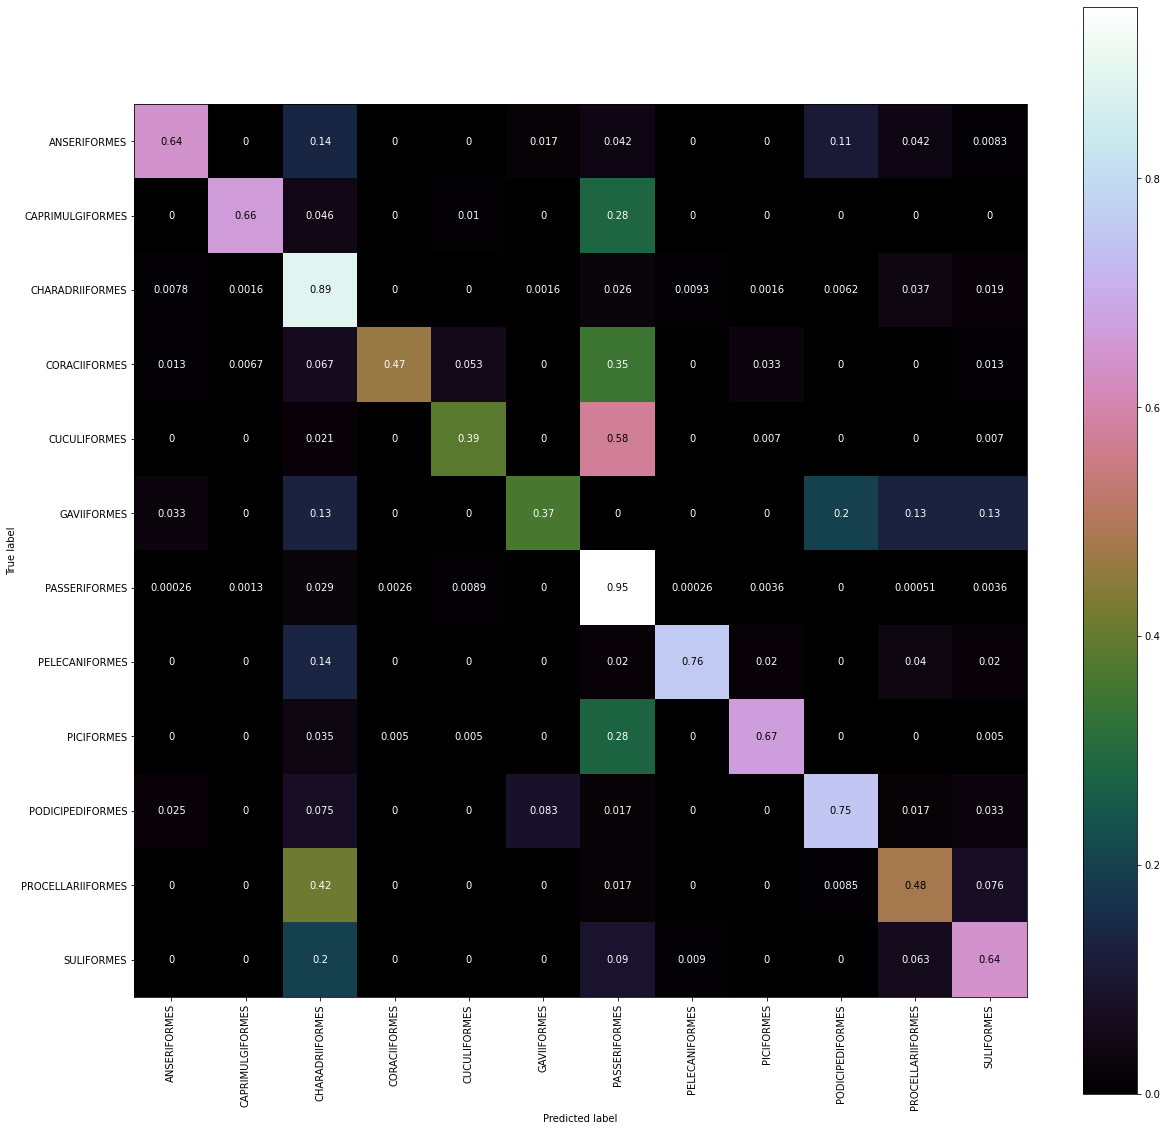

In [91]:
cm = metrics.confusion_matrix(y_test_f, pred_f, normalize='true') #set normalize = true to see the % distribution by row 
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='cubehelix')
plt.xticks(rotation=90);

In [ ]:
# LOAD AN EXAMPLE IMAGE

In [29]:
def load_image(path):
    images = Image.open(f'./../CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

In [30]:
example1=load_image("017.Cardinal/Cardinal_0022_17233.jpg")
example2=np.asarray(example1)
example3 = example2.reshape(1, 128, 128, 3)

In [31]:
predictions1=new_model_uploaded.predict(example3) 
pred_f1=np.argmax(predictions1,axis=1)


In [45]:
predictions1


array([[6.1056737e-12, 3.5156714e-07, 1.2836688e-05, 1.9924647e-04,
        2.2087386e-06, 8.6521568e-06, 8.0251948e-07, 9.9976486e-01,
        9.7821123e-07, 8.8709967e-06, 2.6225090e-08, 7.8682473e-07,
        4.9166164e-07]], dtype=float32)

In [62]:
max_pred=np.max(predictions1)
max_pred_perc=max_pred*100
format_pred_perc = "{:.2f}".format(max_pred_perc)
print (f'The model is {format_float}% sure that this species belongs to THAT!')

The model is 99.98% sure that this species belongs to THAT!


In [54]:
max_pred=np.max(predictions1)
result=np.where(predictions1==max_pred)
classification_index=result[1]
classification_index
#print("Elements with max value exists at following indices", result[1])

array([7], dtype=int64)

In [55]:
print(pred_f1)
print(int(pred_f1))

[7]
7


In [65]:
class_names[int(pred_f1)-1]

'PASSERIFORMES'

In [70]:
#Function to upload an image 
def load_image_new(path):
    images = Image.open(f'{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    floaters3=np.asarray(floaters2)
    floaters4 = floaters3.reshape(1, 128, 128, 3)
    return floaters4

In [131]:
order_names_sorted

[(1, 'Anseriformes'),
 (2, 'Caprimulgiformes'),
 (3, 'Charadriiformes'),
 (4, 'Coraciiformes'),
 (5, 'Cuculiformes'),
 (6, 'Gaviiformes'),
 (7, 'Passeriformes'),
 (8, 'Pelecaniformes'),
 (9, 'Piciformes'),
 (10, 'Podicipediformes'),
 (11, 'Procellariiformes'),
 (12, 'Suliformes')]

In [145]:
class_names_dict={
0:"ANSERIFORMES",
1:"CAPRIMULGIFORMES",
2:"CHARADRIIFORMES",
3:"CORACIIFORMES",
4:"CUCULIFORMES",
5:"GAVIIFORMES",
6:"PASSERIFORMES",
7:"PELECANIFORMES",
8:"PICIFORMES",
9:"PODICIPEDIFORMES",
10:"PROCELLARIIFORMES",
11:"SULIFORMES"
}

In [147]:
predictions3

array([[1.0901128e-21, 4.8088803e-12, 3.1519714e-09, 4.9259569e-07,
        6.3373384e-13, 2.6862508e-09, 5.4394066e-11, 9.9999952e-01,
        9.4033548e-13, 1.2013467e-10, 3.3951086e-14, 2.3698181e-12,
        1.7745485e-13]], dtype=float32)

In [148]:
test_case1=load_image_new("test_images/cardinal_1.jpg")

predictions3=new_model_uploaded.predict(test_case1) 
pred_f3=np.argmax(predictions3,axis=1)

good_name=order_names_sorted[int(pred_f3)]
final=class_names_dict.get(int(pred_f3)-1).title()
print(final)
print(class_names[int(pred_f3)])
print(pred_f3)
print(good_name)

Passeriformes
PELECANIFORMES
[7]
(8, 'Pelecaniformes')


In [87]:
predictions3

array([[1.0901128e-21, 4.8088803e-12, 3.1519714e-09, 4.9259569e-07,
        6.3373384e-13, 2.6862508e-09, 5.4394066e-11, 9.9999952e-01,
        9.4033548e-13, 1.2013467e-10, 3.3951086e-14, 2.3698181e-12,
        1.7745485e-13]], dtype=float32)

In [89]:
## Streamlit Test Code

In [107]:
#Function to upload an image 
def load_image_new(path):
    images = Image.open(path) 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    floaters3=np.asarray(floaters2)
    floaters4 = floaters3.reshape(1, 128, 128, 3)
    return floaters4

In [108]:
test_case1=load_image_new("test_images/albatross.jpg")

In [135]:
#function to classify birds in Streamlit

def predict_birds_order_with_prob(file):
    best_model_1 = tf.keras.models.load_model('saved_models/order_es.h5')
    preds1=best_model_1.predict(file)
    preds2=np.argmax(preds1,axis=1)
    good_name=order_names_sorted[int(preds2)-1]
    max_pred=np.max(preds1)
    max_pred_perc=max_pred*100
    format_pred_perc = "{:.2f}".format(max_pred_perc)
    return format_pred_perc, good_name[1]


In [136]:
predict_birds_order_with_prob(test_case1)

('100.00', 'Passeriformes')

In [115]:
order_names_sorted[int(preds2)]

NameError: name 'preds2' is not defined

## Previous Models 

In [23]:
model_alt6 = Sequential([ base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model_alt6.add(Flatten(input_shape = (128, 128, 3)))
model_alt6.add(Dense(200, activation = 'relu'))
model_alt6.add(Dense(128, activation = 'relu'))
model_alt6.add(Dense(128, activation = 'relu'))
model_alt6.add(Dense(64, activation = 'relu'))
model_alt6.add(Dense(48, activation = 'relu'))

model_alt6.add(Dense(13, activation = 'softmax'))
# Compile model.
model_alt6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_alt6.trainable = True
history_alt6  = model_alt6.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=30,
                    verbose=1)

Epoch 1/30
24/24 [==============================] - 114s 5s/step - loss: 1.2061 - accuracy: 0.6900 - val_loss: 0.6535 - val_accuracy: 0.8124
Epoch 2/30
24/24 [==============================] - 109s 5s/step - loss: 0.5725 - accuracy: 0.8207 - val_loss: 0.5318 - val_accuracy: 0.8345
Epoch 3/30
24/24 [==============================] - 102s 4s/step - loss: 0.4103 - accuracy: 0.8674 - val_loss: 0.4761 - val_accuracy: 0.8519
Epoch 4/30
24/24 [==============================] - 103s 4s/step - loss: 0.3123 - accuracy: 0.8992 - val_loss: 0.4577 - val_accuracy: 0.8585
Epoch 5/30
24/24 [==============================] - 102s 4s/step - loss: 0.2531 - accuracy: 0.9149 - val_loss: 0.4166 - val_accuracy: 0.8697
Epoch 6/30
24/24 [==============================] - 101s 4s/step - loss: 0.1759 - accuracy: 0.9431 - val_loss: 0.4548 - val_accuracy: 0.8697
Epoch 7/30
24/24 [==============================] - 77s 3s/step - loss: 0.1390 - accuracy: 0.9543 - val_loss: 0.4988 - val_accuracy: 0.8685
Epoch 8/30
24/

In [33]:
history_full=[
("Run 5",history_alt5.history['accuracy'][-1], history_alt5.history['val_accuracy'][-1]),
("Run 6",history_alt6.history['accuracy'][-1], history_alt6.history['val_accuracy'][-1])
]
history_full

[('Run 5', 0.7183850407600403, 0.7166033983230591),
 ('Run 6', 0.9986653327941895, 0.8671038746833801)]

In [34]:
df = pd.DataFrame(history_full, columns=['Name','Training Accuracy', 'Testing Accuracy'])

df.head()

,Name,Training Accuracy,Testing Accuracy
0,Run 5,0.718385,0.716603
1,Run 6,0.998665,0.867104


In [11]:
model_alt7 = Sequential([base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model_alt7.add(Flatten(input_shape = (128, 128, 3)))
model_alt7.add(Dense(256, activation = 'relu'))
model_alt7.add(Dense(200, activation = 'relu'))
model_alt7.add(Dense(128, activation = 'relu'))
model_alt7.add(Dense(128, activation = 'relu'))
model_alt7.add(Dense(64, activation = 'relu'))
model_alt7.add(Dense(48, activation = 'relu'))

model_alt7.add(Dense(13, activation = 'softmax'))
# Compile model.
model_alt7.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_alt7  = model_alt7.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=30,
                    verbose=1)

Epoch 1/30
24/24 [==============================] - 61s 2s/step - loss: 1.2068 - accuracy: 0.6707 - val_loss: 0.7466 - val_accuracy: 0.7884
Epoch 2/30
24/24 [==============================] - 67s 3s/step - loss: 0.6551 - accuracy: 0.8003 - val_loss: 0.5592 - val_accuracy: 0.8269
Epoch 3/30
24/24 [==============================] - 69s 3s/step - loss: 0.4671 - accuracy: 0.8463 - val_loss: 0.5045 - val_accuracy: 0.8419
Epoch 4/30
24/24 [==============================] - 70s 3s/step - loss: 0.3474 - accuracy: 0.8857 - val_loss: 0.4472 - val_accuracy: 0.8597
Epoch 5/30
24/24 [==============================] - 73s 3s/step - loss: 0.2670 - accuracy: 0.9117 - val_loss: 0.4658 - val_accuracy: 0.8528
Epoch 6/30
24/24 [==============================] - 75s 3s/step - loss: 0.2283 - accuracy: 0.9271 - val_loss: 0.5065 - val_accuracy: 0.8552
Epoch 7/30
24/24 [==============================] - 77s 3s/step - loss: 0.1862 - accuracy: 0.9328 - val_loss: 0.4999 - val_accuracy: 0.8628
Epoch 8/30
24/24 [==

KeyboardInterrupt: 

In [ ]:
history_full=[
("Run 5",history_alt5.history['accuracy'][-1], history_alt5.history['val_accuracy'][-1]),
("Run 6",history_alt6.history['accuracy'][-1], history_alt6.history['val_accuracy'][-1])
]
history_full

In [ ]:
df = pd.DataFrame(history_full, columns=['Name','Training Accuracy', 'Testing Accuracy'])

df.head()

In [ ]:
## Confusion Matrix

In [ ]:
# Prep data for confusion matrix
predictions=model7.predict(X_test) 
pred_f=np.argmax(predictions,axis=1)
y_test_f=np.argmax(y_test,axis=1)

In [ ]:
cm = metrics.confusion_matrix(y_test_f, pred_f)
cm

In [ ]:
class_names=[
"ANSERIFORMES",
"CAPRIMULGIFORMES",
"CHARADRIIFORMES",
"CORACIIFORMES",
"CUCULIFORMES",
"GAVIIFORMES",
"PASSERIFORMES",
"PELECANIFORMES",
"PICIFORMES",
"PODICIPEDIFORMES",
"PROCELLARIIFORMES",
"SULIFORMES"
]

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot();